# Previsione della Qualità dell'Aria - **Allenamento con Dati Augmentati e Valutazione dei Modelli**

## Caricamento dei Datasets ed Import Librerie



In [190]:
!pip install pykan

In [191]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import json
import inspect
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import types
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    ParameterSampler
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn.utils.prune as prune
from torch.nn.functional import softmax
from torch.utils.data.sampler import WeightedRandomSampler

%pip install xgboost
import xgboost as xgb
from kan import *

N_JOBS = -1
RANDOM_STATE = 42

In [ ]:
github_url = 'https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/augmented_dataset.csv'
local_path = '/scratch.hpc/martin.tomassi/datasets_pm'
local_file = os.path.join(local_path, 'augmented_dataset.csv')

if not os.path.exists(local_path):
    os.makedirs(local_path)

if not os.path.exists(local_file):
    df = pd.read_csv(github_url,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)
    df.to_csv(local_file, index=False)
    print("File scaricato e salvato in locale.")
else:
    print("Il file esiste già in locale, lo carico...")
    df = pd.read_csv(local_file,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)

obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("category")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2018)]
df = df.reset_index(drop=True)
df.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,pm_lag_1D,co_lag_1D,o3_lag_1D,pm_lag_2D,co_lag_2D,o3_lag_2D,pm_lag_3D,co_lag_3D,o3_lag_3D,Class
0,2015,1,1,Maharashtra,79.599167,0.530417,0.040000,3,1,1,...,72.839583,0.496875,0.040000,103.928333,0.555208,0.040000,84.983333,0.536458,0.040000,4
1,2015,1,1,Delhi,208.485000,7.348611,45.935000,3,1,1,...,152.354819,5.181072,35.782978,87.538462,8.608974,11.974359,87.970588,9.264706,13.470588,5
2,2015,1,1,Bihar,92.000000,0.740000,43.160000,3,1,1,...,92.000000,0.740000,43.160000,92.000000,0.740000,43.160000,92.000000,0.740000,43.160000,4
3,2015,1,1,Telangana,28.290625,0.210000,52.710000,3,1,1,...,28.290625,0.210000,52.710000,28.290625,0.210000,52.710000,28.290625,0.210000,52.710000,2
4,2015,1,1,Tamil Nadu,0.140000,1.182778,11.367708,3,1,1,...,0.140000,0.736597,17.763750,0.140000,0.837778,21.205000,0.140000,0.892917,26.220625,1


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13263 entries, 0 to 13262
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        13263 non-null  int64   
 1   month       13263 non-null  int64   
 2   dayofmonth  13263 non-null  int64   
 3   state       13263 non-null  category
 4   PM2.5       13263 non-null  float64 
 5   CO          13263 non-null  float64 
 6   O3          13263 non-null  float64 
 7   dayofweek   13263 non-null  int64   
 8   quarter     13263 non-null  int64   
 9   weekofyear  13263 non-null  int64   
 10  dayofyear   13263 non-null  int64   
 11  pm_lag_1Y   10835 non-null  float64 
 12  co_lag_1Y   10835 non-null  float64 
 13  o3_lag_1Y   10835 non-null  float64 
 14  pm_lag_2Y   9921 non-null   float64 
 15  co_lag_2Y   9921 non-null   float64 
 16  o3_lag_2Y   9921 non-null   float64 
 17  pm_lag_1M   13023 non-null  float64 
 18  co_lag_1M   13023 non-null  float64 
 19  o3_l

In [195]:
class_counts = df['Class'].value_counts()
print(class_counts)

Class
4    4496
2    3773
3    2608
5    1445
6     535
1     406
Name: count, dtype: int64


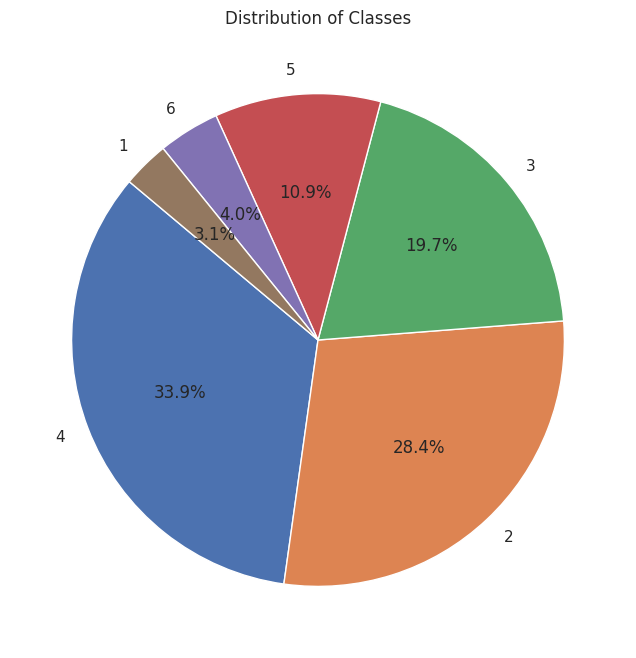

In [196]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_1D`: PM2.5 ritardato di 1 giorno
- `pm_lag_2D`: PM2.5 ritardato di 2 giorni
- `pm_lag_3D`: PM2.5 ritardato di 3 giorni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_1D`: CO ritardato di 1 giorno
- `co_lag_2D`: CO ritardato di 2 giorni
- `co_lag_3D`: CO ritardato di 1 anno
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_1D`: O3 ritardato di 1 giorno
- `o3_lag_2D`: O3 ritardato di 2 giorni
- `o3_lag_3D`: O3 ritardato di 3 giorni

La variabile target per il nostro modello di addestramento sarà una variabile **discreta**, composta da 6 valori distinti. Questi valori rappresentano i diversi livelli di qualità dell'aria, come definiti dalla scala dell'**Environmental Protection Agency (EPA)** degli Stati Uniti per la concentrazione di PM2.5.

Possiamo mappare numericamente questi livelli alle seguenti classi, mantenendo l'ordine implicito di gravità:

* **1: "Good"** (Concentrazione di PM2.5: $0 - 9.0 \mu g/m^3$)
* **2: "Moderate"** (Concentrazione di PM2.5: $9.1 - 35.4 \mu g/m^3$)
* **3: "Unhealthy for Sensitive Groups"** (Concentrazione di PM2.5: $35.5 - 55.4 \mu g/m^3$)
* **4: "Unhealthy"** (Concentrazione di PM2.5: $55.5 - 125.4 \mu g/m^3$)
* **5: "Very Unhealthy"** (Concentrazione di PM2.5: $125.5 - 225.4 \mu g/m^3$)
* **6: "Hazardous"** (Concentrazione di PM2.5: $> 225.5 \mu g/m^3$)

Adottando questo schema, il problema si configura come un task di **classificazione multi-classe**. L'obiettivo del modello sarà prevedere a quale di questi 6 livelli di qualità dell'aria (o "categorie di rischio") appartiene una data osservazione, basandosi sulle caratteristiche di input fornite.

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [197]:
target = 'Class'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W','pm_lag_1D','co_lag_1D','o3_lag_1D','pm_lag_2D','co_lag_2D','o3_lag_2D','pm_lag_3D','co_lag_3D','o3_lag_3D']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [198]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [199]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati eliminando l’indice precedente,
# in modo da partire da zero ed avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [200]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7936 entries, 0 to 7935
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  7936 non-null   int64   
 1   dayofweek   7936 non-null   int64   
 2   dayofyear   7936 non-null   int64   
 3   weekofyear  7936 non-null   int64   
 4   month       7936 non-null   int64   
 5   quarter     7936 non-null   int64   
 6   year        7936 non-null   int64   
 7   state       7936 non-null   category
 8   pm_lag_1Y   7936 non-null   float64 
 9   pm_lag_2Y   7936 non-null   float64 
 10  pm_lag_1M   7936 non-null   float64 
 11  pm_lag_1W   7936 non-null   float64 
 12  co_lag_1Y   7936 non-null   float64 
 13  co_lag_2Y   7936 non-null   float64 
 14  co_lag_1M   7936 non-null   float64 
 15  co_lag_1W   7936 non-null   float64 
 16  o3_lag_1Y   7936 non-null   float64 
 17  o3_lag_2Y   7936 non-null   float64 
 18  o3_lag_1M   7936 non-null   float64 
 19  o3_lag

In [201]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  1985 non-null   int64   
 1   dayofweek   1985 non-null   int64   
 2   dayofyear   1985 non-null   int64   
 3   weekofyear  1985 non-null   int64   
 4   month       1985 non-null   int64   
 5   quarter     1985 non-null   int64   
 6   year        1985 non-null   int64   
 7   state       1985 non-null   category
 8   pm_lag_1Y   1985 non-null   float64 
 9   pm_lag_2Y   1985 non-null   float64 
 10  pm_lag_1M   1985 non-null   float64 
 11  pm_lag_1W   1985 non-null   float64 
 12  co_lag_1Y   1985 non-null   float64 
 13  co_lag_2Y   1985 non-null   float64 
 14  co_lag_1M   1985 non-null   float64 
 15  co_lag_1W   1985 non-null   float64 
 16  o3_lag_1Y   1985 non-null   float64 
 17  o3_lag_2Y   1985 non-null   float64 
 18  o3_lag_1M   1985 non-null   float64 
 19  o3_lag

In [202]:
print(y_train.value_counts())

Class
4    3150
3    1625
2    1487
5    1138
6     423
1     113
Name: count, dtype: int64


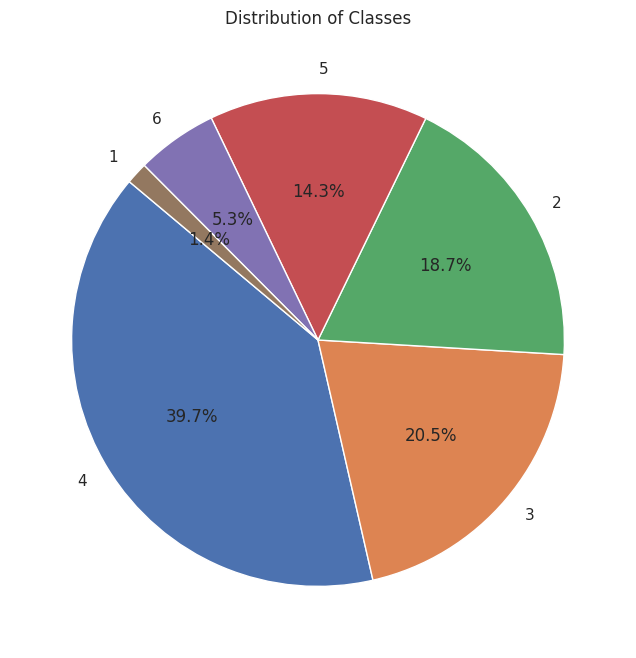

In [203]:
plt.figure(figsize=(8, 8))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

In [204]:
print(y_test.value_counts())

Class
4    683
2    615
3    376
5    197
6    100
1     14
Name: count, dtype: int64


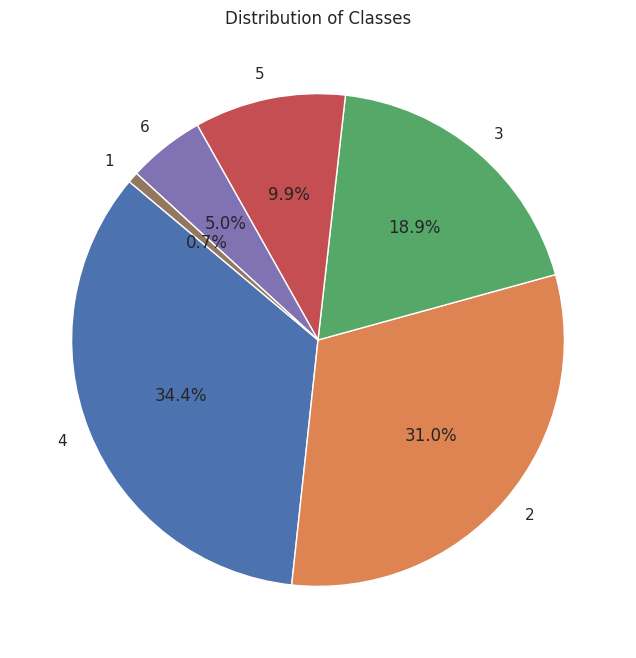

In [205]:
plt.figure(figsize=(8, 8))
plt.pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [206]:
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()
numerical_features   = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [207]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Queste metriche sono state scelte specificamente per valutare l'efficacia dei modelli in problemi di **classificazione multi-classe, con particolare attenzione alle classi sbilanciate**.

Le metriche calcolate sono:

1.  **Accuracy Score**
    Misura la percentuale di istanze classificate correttamente dal modello. Sebbene sia una metrica intuitiva, può essere fuorviante in presenza di classi sbilanciate, poiché un modello che classifica correttamente solo la classe maggioritaria può comunque mostrare un'alta accuratezza.
    *(Più alto è, meglio è.)*

2.  **F1-Score (Weighted)**
    L'F1-Score è la media armonica della Precisione e del Recall. La versione "weighted" calcola la media di F1-Score per ciascuna classe, pesandola in base al numero di istanze di quella classe nel dataset. Questa metrica è particolarmente utile per dataset con classi sbilanciate, in quanto fornisce una visione più bilanciata delle prestazioni del modello su tutte le classi, evitando di essere dominata dalla classe maggioritaria.
    *(Più alto è, meglio è.)*

3.  **F1-Score (Macro)**
    La versione "macro" dell'F1-Score calcola la media non pesata di F1-Score per ciascuna classe. Questo significa che ogni classe contribuisce in modo uguale alla metrica finale, indipendentemente dal suo numero di campioni. È utile quando tutte le classi, comprese quelle minoritarie, hanno la stessa importanza.
    *(Più alto è, meglio è.)*

4.  **Matrice di Confusione**
    Una tabella che riassume le prestazioni di un algoritmo di classificazione. Mostra il numero di previsioni corrette e sbagliate per ciascuna classe, indicando dove il modello sta confondendo le diverse categorie. È fondamentale per comprendere gli errori specifici del modello.

5.  **Classification Report**
    Fornisce un riepilogo dettagliato delle metriche di Precisione, Recall e F1-Score per ciascuna classe, oltre a metriche aggregate (macro avg, weighted avg). È uno strumento essenziale per una valutazione approfondita delle prestazioni per classe.

6.  **AUC-ROC (Area Under the Receiver Operating Characteristic Curve) - One-vs-Rest Weighted**
    L'AUC-ROC misura la capacità del modello di distinguere tra le classi. Per problemi multi-classe, si calcola spesso in modalità "one-vs-rest", trattando ogni classe come "positiva" e tutte le altre come "negative". La versione "weighted" ne calcola la media pesata per la frequenza delle classi, rendendola più robusta per dataset sbilanciati. Un valore più vicino a 1 indica una maggiore capacità discriminatoria.
    *(Più alto è, meglio è.)*

7.  **AUC-PR (Area Under the Precision-Recall Curve) - One-vs-Rest Weighted**
    L'AUC-PR è particolarmente utile per dataset con classi sbilanciate e quando la classe positiva (minoritaria) è di maggiore interesse. Misura l'area sotto la curva Precision-Recall, offrendo una valutazione più accurata della capacità del modello di identificare correttamente le istanze positive rispetto all'AUC-ROC, che può essere ottimistica in presenza di un grande numero di veri negativi. Per multi-classe, viene calcolata in modalità "one-vs-rest" e mediata pesando per la frequenza delle classi.
    *(Più alto è, meglio è.)*

In [208]:
def count_params(model):
    if isinstance(model, ImbPipeline):
        model = model.steps[-1][1]

    if hasattr(model, 'parameters') and inspect.ismethod(model.parameters) and not isinstance(model, KAN):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0
            else:
                sum_edge_terms = 0
                for i in range(len(model.width) - 1):
                    Nl = model.width[i]
                    Nl_plus_1 = model.width[i+1]
                    if isinstance(Nl, list): Nl = Nl[0]
                    if isinstance(Nl_plus_1, list): Nl_plus_1 = Nl_plus_1[0]
                    G = model.grid
                    k = model.k
                    sum_edge_terms += Nl * Nl_plus_1 * (G + k - 1)
                return sum_edge_terms
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0

    elif isinstance(model, RandomForestClassifier):
        total_nodes = 0
        if hasattr(model, 'estimators_'):
            for tree in model.estimators_:
                if hasattr(tree, 'tree_'):
                    total_nodes += tree.tree_.node_count
            return total_nodes
        else:
            return 0

    elif isinstance(model, xgb.XGBClassifier):
        total_nodes = 0

        try:
            booster = model.get_booster()
            tree_dumps = booster.get_dump(dump_format='json')

            def count_nodes_in_json_tree(node):
                count = 1
                if 'children' in node:
                    for child in node['children']:
                        count += count_nodes_in_json_tree(child)
                return count

            for tree_dump_str in tree_dumps:
                tree_json = json.loads(tree_dump_str)
                total_nodes += count_nodes_in_json_tree(tree_json)

            return total_nodes
        except Exception as e:
            print(f"Error calculating exact XGBoost complexity: {e}")
            return 0
    else:
        return 0

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_estimator_scores(model_name, model, X_test, y_test, X_train, y_train, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} ---")

    # Calcola la Complessitá dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters/Nodes: {param_count}")

    # Previsioni (etichette hard) per test e train
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Se il modello supporta predict_proba (per AUC)
    y_proba_test = None
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test) # Probabilità per ogni classe

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train, y_pred_train)
    f1_weighted_tr = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test, y_pred_test)
    f1_weighted_te = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI per F1-weighted
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='macro', zero_division=0
    )

    # Matrice di Confusione e Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred_test))

    # Raccolta dei punteggi
    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC se possibile (necessita probabilità)
    if y_proba_test is not None:
        try:
            num_classes = len(np.unique(y_test))
            auc_roc_ovr = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr_ovr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')

            # Bootstrap per AUC-ROC e AUC-PR
            auc_roc_low, auc_roc_high = bootstrap_ci(
                lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
                y_test, y_proba_test
            )
            auc_pr_low, auc_pr_high = bootstrap_ci(
                lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
                y_test, y_proba_test
            )

            scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
            print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
            print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

        except ValueError as e:
            print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
            scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    else:
        print("Modello non supporta predict_proba. AUC/PR non calcolabili.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC

    all_scores_list.append(scores_row)


def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    return out # Restituisce logit/probabilità, non etichette hard qui


def get_torch_estimator_scores(model_name, model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor,
                               device, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} (PyTorch) ---")

    # Calcola il numero di Parametri dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters: {param_count}")

    # Ottieni output (logits/probabilità) dal modello
    y_pred_proba_train = predict_torch(model, X_train_tensor, device)
    y_pred_proba_test = predict_torch(model, X_test_tensor, device)

    # Converti le etichette vere (tensori) in numpy array per Scikit-learn
    y_train_np = y_train_tensor.detach().cpu().numpy()
    y_test_np = y_test_tensor.detach().cpu().numpy()

    # Se il modello emette logit, converti in probabilità e poi in etichette
    y_pred_labels_train = torch.argmax(softmax(y_pred_proba_train, dim=1), dim=1).detach().cpu().numpy()
    y_pred_labels_test = torch.argmax(softmax(y_pred_proba_test, dim=1), dim=1).detach().cpu().numpy()

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train_np, y_pred_labels_train)
    f1_weighted_tr = f1_score(y_train_np, y_pred_labels_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train_np, y_pred_labels_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test_np, y_pred_labels_test)
    f1_weighted_te = f1_score(y_test_np, y_pred_labels_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test_np, y_pred_labels_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_np, y_pred_labels_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test_np, y_pred_labels_test))

    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC (necessita probabilità)
    try:
        auc_roc_ovr = roc_auc_score(y_test_np, softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                    multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_test_np), softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                            average='weighted')

        # Bootstrap per AUC-ROC e AUC-PR
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, softmax(torch.tensor(yp), dim=1).numpy(), multi_class='ovr', average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), softmax(torch.tensor(yp), dim=1).numpy(), average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    except Exception as e:
        print(f"Errore generico nel calcolo di AUC/PR per PyTorch: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN

    all_scores_list.append(scores_row)

## Cross Validation TimeSeriesSplit
La validazione viene eseguita con `TimeSeriesSplit`, una tecnica di cross-validation adatta alle Serie Temporali, che preserva l’ordine cronologico dividendo il dataset in fold sequenziali.

In [209]:
tscv = TimeSeriesSplit(n_splits=5)

Nel blocco seguente viene visualizzata la suddivisione del dataset nei 5 fold della Time Series Cross-Validation.  
Questa rappresentazione è utile per verificare che la sequenza temporale sia rispettata nella divisione dei dati tra training e validation set.


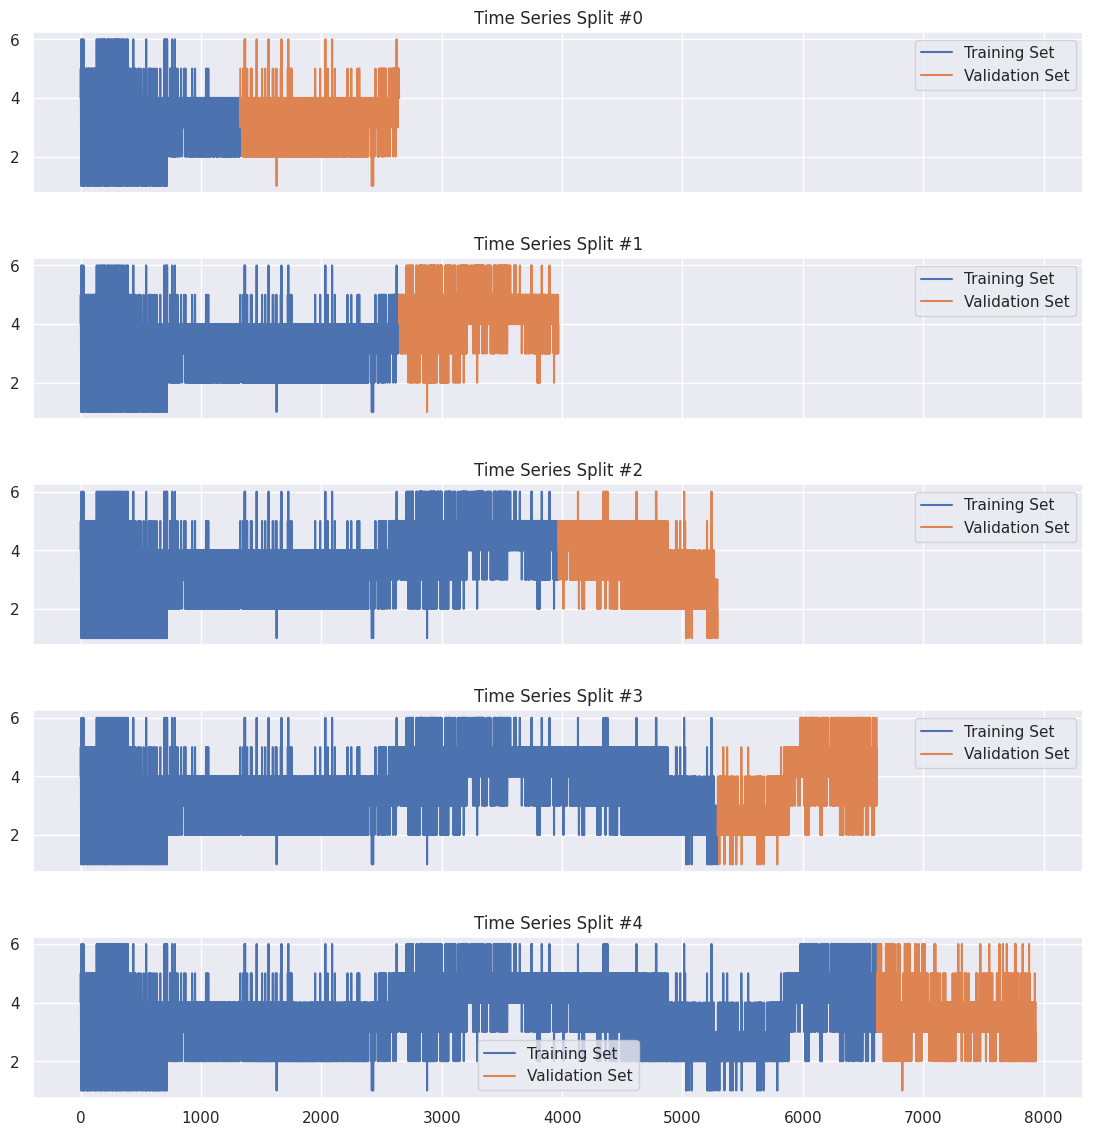

In [210]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)): # Usa y_train qui
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

## Random forest
Il modello Random Forest è un ensemble di alberi decisionali che migliora la stabilità e la capacità predittiva rispetto a un singolo albero. Ogni albero viene addestrato su un sottoinsieme casuale del dataset (bagging) e valuta solo una parte delle feature, rendendo l’insieme più robusto a overfitting e variazioni nei dati.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `max_samples=0.2`: ogni albero è addestrato su un campione casuale del 20% dei dati originali (con ripetizione);
- `max_features='sqrt'`: ogni nodo dell’albero valuta solo un sottoinsieme di feature pari alla radice quadrata del numero totale di feature disponibili;
- `n_estimators=200`: il modello è composto da 200 alberi decisionali;
- `max_depth=None`: gli alberi possono crescere fino a foglie pure, senza una profondità massima prefissata;
- `n_jobs=-1`: sfrutta tutti i core CPU disponibili per il training parallelo;
- `random_state=RANDOM_STATE`: Per la riproducibilità.
- `class_weight='balanced'`: attribuisce un peso inversamente proporzionale alla frequenza delle classi per gestire eventuali sbilanciamenti nel dataset.

In [211]:
model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(max_samples=0.2, max_features="sqrt",
                                    n_estimators=200, max_depth=None,
                                    n_jobs=N_JOBS, random_state=RANDOM_STATE,
                                    class_weight='balanced'))
])

In [212]:
%time model.fit(X_train, y_train)
print()

CPU times: user 6.04 s, sys: 40.6 ms, total: 6.08 s
Wall time: 8.46 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [213]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

,0
numeric__pm_lag_1D,0.200749
numeric__pm_lag_2D,0.117602
numeric__pm_lag_3D,0.097000
numeric__pm_lag_1W,0.073967
numeric__pm_lag_1M,0.053145
numeric__pm_lag_1Y,0.036112
numeric__co_lag_1D,0.026075
numeric__dayofyear,0.025465
numeric__co_lag_2D,0.020843
numeric__co_lag_3D,0.020473


### Hyperparameter Tuning per Random Forest

Eseguiamo una ricerca randomizzata (`RandomizedSearchCV`) per ottimizzare un insieme ampio di iperparametri fondamentali del modello Random Forest:

- `n_estimators`: numero di alberi nella foresta;
- `max_samples`: frazione massima di campioni usata per addestrare ogni singolo albero;
- `max_depth`: profondità massima degli alberi;
- `min_samples_leaf`: numero minimo di campioni richiesti per una foglia;
- `max_features`: numero massimo di feature da considerare per ogni split.

In questa fase di tuning, la pipeline include anche la tecnica di oversampling **SMOTE**, applicata correttamente all'interno di ogni fold di **Time Series Cross-Validation** per evitare il data leakage.

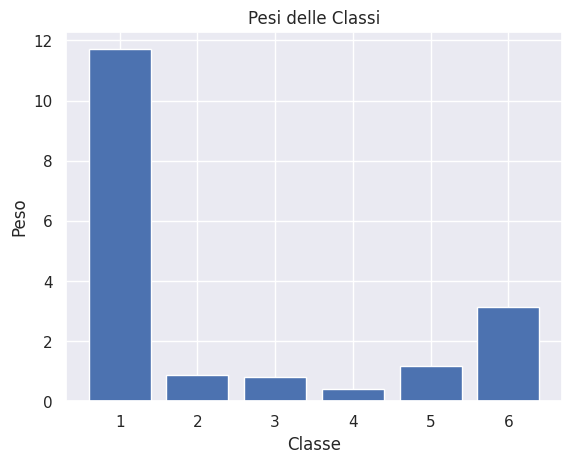

In [214]:
class_labels = np.unique(y_train)
initial_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
initial_class_weight_dict = dict(zip(class_labels, initial_weights))
plt.bar(class_labels, initial_weights)
plt.title('Pesi delle Classi')
plt.xlabel('Classe')
plt.ylabel('Peso')
plt.show()

In [ ]:
grid = {
    'tree__n_estimators': [150, 200, 250],
    'tree__max_samples': [0.5, 0.8, 1.0],
    'tree__max_depth': [5, 10, 20],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [2, 5, 10],
    'tree__max_features': ['sqrt', 'log2']
}
model_ht = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])
gs_rf = RandomizedSearchCV(model_ht, grid, n_iter=111, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 486
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 162.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{486}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{476}{486}\right)} = \frac{-2.3026}{\ln(476/486)} \approx \frac{2.3026}{0.0208} \approx 110.70
$$

Quindi, con **111 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 162 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [216]:
%time gs_rf.fit(X_train, y_train)
print()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 10.6 s, sys: 33.1 ms, total: 10.6 s
Wall time: 41.2 s



In [217]:
get_estimator_scores("random_forest", gs_rf.best_estimator_, X_test, y_test, X_train, y_train, all_scores)


--- Valutazione Prestazioni per random_forest ---
Model Parameters/Nodes: 225262

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.18      0.43      0.26        14
           2       0.80      0.81      0.80       615
           3       0.50      0.58      0.54       376
           4       0.81      0.72      0.76       683
           5       0.65      0.61      0.63       197
           6       0.66      0.76      0.70       100

    accuracy                           0.71      1985
   macro avg       0.60      0.65      0.62      1985
weighted avg       0.72      0.71      0.71      1985


Confusion Matrix (Test Set):
[[  6   7   0   0   0   1]
 [ 27 496  78  12   2   0]
 [  0  90 217  68   1   0]
 [  0  21 122 489  48   3]
 [  0   4   7  29 121  36]
 [  0   0   6   4  14  76]]
AUC-ROC (OVR, Weighted): 0.921
AUC-PR (OVR, Weighted): 0.775


## XGBoost

XGBoost è un'implementazione ottimizzata di algoritmi di gradient boosting. A differenza del Random Forest che costruisce alberi indipendenti e poi ne aggrega i risultati, XGBoost costruisce alberi in sequenza, con ogni nuovo albero che corregge gli errori degli alberi precedenti.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `sampler`: **SMOTE (Synthetic Minority Over-sampling Technique)**, che genera nuovi campioni sintetici per le classi minoritarie, rendendo il dataset più bilanciato per l'addestramento. `random_state` garantisce la riproducibilità.
- `xgb`: il classificatore XGBoost con i seguenti iperparametri iniziali:
    - `objective='multi:softprob'`: Specifica la funzione obiettivo di classificazione multi-classe, dove l'output è un array di probabilità per ogni classe. Questo è necessario per le metriche AUC.
    - `num_class`: numero totale di classi.
    - `n_estimators=200`: numero di alberi di boosting da costruire.
    - `learning_rate=0.1`: La dimensione del passo di ridimensionamento del contributo di ogni albero.
    - `use_label_encoder=False`: parametro deprecato e quindi va disabilitato per evitare warning.
    - `eval_metric='mlogloss'`: metrica di valutazione da usare durante l'addestramento.
    - `n_jobs=N_JOBS`: Sfrutta tutti i core CPU disponibili per il training parallelo.
    - `random_state=RANDOM_STATE`: Per la riproducibilità.

**Nota Importante:** Per XGBoost con multi-classe, le etichette della classe devono essere convertite in indici che partono da 0.

In [ ]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1
num_classes = len(np.unique(y_train_xgb))

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              n_estimators=200,
                              learning_rate=0.1,
                              use_label_encoder=False, # Deprecato, imposto a False
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

In [219]:
%time model.fit(X_train, y_train_xgb)
print()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:49:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CPU times: user 9.56 s, sys: 36.9 ms, total: 9.59 s
Wall time: 9.69 s



Possiamo ricavare le 10 feature più importanti per l'XGBoost Classifier, ovvero le variabili che sono state più utilizzate nella creazione degli alberi di boosting.

In [220]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

,0
numeric__pm_lag_1D,0.410160
categorical__state_Karnataka,0.045690
numeric__dayofweek,0.026956
categorical__state_Telangana,0.023730
numeric__quarter,0.021788
categorical__state_Gujarat,0.021256
categorical__state_Bihar,0.020549
numeric__pm_lag_3D,0.020321
categorical__state_Uttar Pradesh,0.019335
categorical__state_Haryana,0.018526


### Hyperparameter Tuning per XGBoost
Eseguiamo una ricerca esaustiva (GridSearchCV) per ottimizzare iperparametri fondamentali del modello XGBoost, combinandoli con la tecnica di resampling SMOTE. Ottimizzeremo:
- `n_estimators`: Numero di alberi di boosting.
- `learning_rate`: La dimensione del passo che riduce il contributo di ogni nuovo albero.
- `max_depth`: La profondità massima di un albero.

In questa fase di tuning, la pipeline includerà anche la tecnica di oversampling SMOTE, che verrà applicata in modo appropriato a ogni fold di cross-validation per garantire che il modello sia addestrato su un dataset bilanciato senza data leakage.


---

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 2187
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 27.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{2187}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{2177}{2187}\right)} = \frac{-2.3026}{\ln(\frac{2177}{2187})} \approx \frac{2.3026}{0.0046} \approx 500.57
$$

Quindi, con **501** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 27 combinazioni.

---

In [ ]:
grid = {
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.05, 0.1, 0.2],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__subsample": [0.7, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.9, 1.0],
    "xgb__gamma": [0, 0.2, 0.4],
    "xgb__min_child_weight": [1, 5, 10],
}
model_ht = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              use_label_encoder=False, # Deprecato
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])
gs_xgb = RandomizedSearchCV(model_ht, grid, n_iter=501, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

In [222]:
%time gs_xgb.fit(X_train, y_train_xgb)
print()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:49:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CPU times: user 3.45 s, sys: 20.1 ms, total: 3.47 s
Wall time: 13.5 s



In [223]:
get_estimator_scores("xgboost", gs_xgb.best_estimator_, X_test, y_test_xgb, X_train, y_train_xgb, all_scores)


--- Valutazione Prestazioni per xgboost ---
Model Parameters/Nodes: 16332

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.10      0.36      0.15        14
           1       0.81      0.80      0.80       615
           2       0.54      0.51      0.52       376
           3       0.79      0.77      0.78       683
           4       0.66      0.60      0.63       197
           5       0.60      0.72      0.65       100

    accuracy                           0.71      1985
   macro avg       0.58      0.63      0.59      1985
weighted avg       0.72      0.71      0.71      1985


Confusion Matrix (Test Set):
[[  5   7   2   0   0   0]
 [ 44 489  68   9   1   4]
 [  1  81 193  98   2   1]
 [  1  19  90 528  37   8]
 [  0   4   5  34 118  36]
 [  0   3   2   3  20  72]]
AUC-ROC (OVR, Weighted): 0.921
AUC-PR (OVR, Weighted): 0.777


## MLP and KAN


In [224]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout, num_classes):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def build_kan(input_dim, width, grid, k, num_classes, seed=0):
    model = KAN(
        width=[input_dim] + list(width) + [num_classes],
        grid=grid,
        k=k,
        seed=seed,
        device=device
    )
    model.speed()  # enable efficient mode: disable symbolic branch
    return model

Device utilizzato: cuda


### Implementazione dell’Early Stopping

La classe `EarlyStopper` implementa una logica di early stopping che interrompe anticipatamente l’addestramento se la performance sul validation set non migliora oltre una soglia (min_delta) per un numero consecutivo di epoche (patience).
Questo approccio aiuta a evitare l’overfitting e riduce i tempi di addestramento, salvando il modello con la miglior loss di validazione osservata.

In [225]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue una singola epoca di training. Calcola le previsioni, applica la loss function, esegue il backpropagation e aggiorna i pesi del modello. La loss viene aggregata e normalizzata sulla dimensione del dataset.

- `eval_loss`: calcola la loss media del modello sul validation set in modalità eval, disabilitando l’aggiornamento dei pesi. Questo è fondamentale per valutare le prestazioni in modo affidabile durante il training.

In [226]:
def train_epoch(model, loader, optimizer, criterion, l2_lambda=0.0):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)

        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb.long()).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` implementa una strategia di ottimizzazione degli iperparametri che:

- Estrae in modo casuale combinazioni di iperparametri dallo spazio definito (param_dist);
- Valuta ogni configurazione tramite Cross Validation TimeSeriesSplit per rispettare l’ordine temporale dei dati;
- Addestra un modello MLP per ciascun fold monitorando la loss di validazione;
- Applica early stopping durante l’allenamento per evitare overfitting;
- Calcola la media delle validation loss su tutti i fold per ogni configurazione.

La combinazione con la miglior media viene salvata come modello ottimale, insieme agli iperparametri migliori.

In [227]:
def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4,
                  class_weights=None):
    train_keys = ['lr', 'l2_lambda']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Random Search con Time Series Cross Validation...")

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            sub_train_dataset = Subset(dataset, train_idx)
            val_set = Subset(dataset, val_idx)

            # Calcola i pesi dei campioni per il training set del fold corrente
            # Basato sulle etichette originali (0-indexed) del sotto-dataset di training
            train_labels_fold = np.array([dataset.tensors[1][i].item() for i in train_idx])
            unique_labels, counts = np.unique(train_labels_fold, return_counts=True)
            # Pesi inversamente proporzionali alla frequenza
            # Gestisce il caso in cui una classe possa mancare in un fold
            sample_weights = np.zeros(len(train_labels_fold))
            for i, label in enumerate(unique_labels):
                if class_weights is not None and label in class_weights:
                    # Usa il peso globale calcolato prima
                    weight_for_label = class_weights[label]
                else:
                    # Fallback a un peso bilanciato locale se non specificato globalmente o classe mancante
                    weight_for_label = 1. / counts[np.where(unique_labels == label)[0][0]]
                sample_weights[train_labels_fold == label] = weight_for_label

            sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(sample_weights), # Num samples è len(sub_train_dataset) per oversampling proporzionale
                replacement=True # Necessario per oversampling
            )
            # DataLoader con il sampler ponderato per il training
            train_loader = DataLoader(sub_train_dataset, batch_size=32, sampler=sampler)
            # Val loader rimane normale
            val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

            model = model_builder(**model_params)
            if hasattr(model, 'speed'):
                model.speed()
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(1000):
                train_loss = train_epoch(model, train_loader, optimizer, criterion, l2_lambda=train_params.get('l2_lambda', 0.0))
                val_loss = eval_loss(model, val_loader, criterion)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_loss(model, val_loader, criterion)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model_builder(**best_model_params).to(device)
            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

In questa sezione:

- Applichiamo la trasformazione dei dati tramite il preprocessor già definito in precedenza;

- Convertiamo le etichette y_train e y_test in formato 0-indexed, come richiesto dalla CrossEntropyLoss di PyTorch;

- Creiamo un dataset PyTorch (TensorDataset) con input e target;

- Definiamo lo spazio di ricerca per gli iperparametri, tra cui:

 Architettura della rete (hidden_sizes);

 Dropout;

 Tasso di apprendimento (lr);

 Numero di classi.

Calcoliamo infine i pesi delle classi per bilanciare la loss in presenza di squilibri nella distribuzione delle etichette.

In [228]:
X_train_processed = preprocessor.fit_transform(X_train) # Fit and transform on training data
X_test_processed = preprocessor.transform(X_test) # Only transform on test data

y_train_0_indexed = y_train.values - 1
y_test_0_indexed = y_test.values - 1

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train_0_indexed, dtype=torch.long)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
num_classes = len(np.unique(y_train_0_indexed))

mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}
kan_param_dist = {
    'input_dim': [input_dim],
    'width': [(8,4), (16,8)],
    'grid': [5, 10],
    'k': [2, 4],
    'seed': [0],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}

class_labels_0_indexed = np.unique(y_train_0_indexed)
class_weights_balanced = compute_class_weight(class_weight='balanced', classes=class_labels_0_indexed, y=y_train_0_indexed)
class_weights_dict = dict(zip(class_labels_0_indexed, class_weights_balanced))

### Avvio della ricerca e valutazione

- Eseguiamo la funzione random_search, fornendo:

 Il costruttore della rete MLP;

 Lo spazio degli iperparametri;

 Il dataset PyTorch e i pesi delle classi calcolati in precedenza;

- Al termine, il modello con la miglior media di validation loss viene selezionato e restituito;

In [ ]:
print("MLP Results:")
best_model_mlp, model_params_mlp, train_params_mlp = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=15
)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

MLP Results:
Avvio Random Search con Time Series Cross Validation...
Testing parameter set 1/1
  Fold 1/5
    Epoch 0: train_loss = 1.554198, val_loss = 1.931902
    Epoch 10: train_loss = 0.284048, val_loss = 1.198970
    Epoch 20: train_loss = 0.210593, val_loss = 1.172908
    Early stopping at epoch 22, best_val_loss: 1.117205
  Fold 2/5
    Epoch 0: train_loss = 1.440593, val_loss = 2.038082
    Epoch 10: train_loss = 0.496599, val_loss = 1.399662
    Early stopping at epoch 11, best_val_loss: 1.311066
  Fold 3/5
    Epoch 0: train_loss = 1.366888, val_loss = 1.521206
    Epoch 10: train_loss = 0.535285, val_loss = 1.011535
    Early stopping at epoch 17, best_val_loss: 0.983276
  Fold 4/5
    Epoch 0: train_loss = 1.299090, val_loss = 1.233216
    Early stopping at epoch 8, best_val_loss: 0.985951
  Fold 5/5
    Epoch 0: train_loss = 1.280814, val_loss = 1.276811
    Epoch 10: train_loss = 0.586346, val_loss = 1.060502
    Early stopping at epoch 12, best_val_loss: 0.966827
  Mean

---

**Scelta del numero di iterazioni per RandomizedSearchCV con MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 72
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 72.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{72}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{62}{72}\right)} = \frac{-2.3026}{\ln(\frac{62}{72})} \approx \frac{2.3026}{0.1495} \approx 15.4
$$

Quindi, con **15 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 72 combinazioni.

---

In [230]:
get_torch_estimator_scores("MLP", best_model_mlp,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per MLP (PyTorch) ---
Model Parameters: 2470

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.84      0.76      0.80       615
           2       0.41      0.76      0.54       376
           3       0.88      0.34      0.49       683
           4       0.39      0.65      0.48       197
           5       0.59      0.81      0.68       100

    accuracy                           0.60      1985
   macro avg       0.52      0.55      0.50      1985
weighted avg       0.71      0.60      0.60      1985


Confusion Matrix (Test Set):
[[  0  12   1   0   1   0]
 [  0 467 139   3   2   4]
 [  0  61 286  23   4   2]
 [  0  13 248 235 180   7]
 [  0   4  15   6 128  44]
 [  0   1   2   0  16  81]]
AUC-ROC (OVR, Weighted): 0.898
AUC-PR (OVR, Weighted): 0.707


In [ ]:
print("KAN Results:")
best_model_kan, model_params_kan, train_params_kan = random_search(
    lambda **p: build_kan(**p), kan_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=14
)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

KAN Results:
Avvio Random Search con Time Series Cross Validation...
Testing parameter set 1/1
  Fold 1/5
checkpoint directory created: ./model
saving model version 0.0
    Epoch 0: train_loss = 1.715930, val_loss = 1.801104
    Epoch 10: train_loss = 0.397464, val_loss = 1.238332
    Epoch 20: train_loss = 0.229409, val_loss = 1.154004
    Early stopping at epoch 23, best_val_loss: 1.138091
  Fold 2/5
checkpoint directory created: ./model
saving model version 0.0
    Epoch 0: train_loss = 1.666234, val_loss = 1.802431
    Epoch 10: train_loss = 0.426544, val_loss = 1.110980
    Early stopping at epoch 13, best_val_loss: 1.093254
  Fold 3/5
checkpoint directory created: ./model
saving model version 0.0
    Epoch 0: train_loss = 1.644677, val_loss = 1.717763
    Epoch 10: train_loss = 0.414869, val_loss = 0.978311
    Early stopping at epoch 16, best_val_loss: 0.956406
  Fold 4/5
checkpoint directory created: ./model
saving model version 0.0
    Epoch 0: train_loss = 1.582000, val_loss 

---

**Scelta del numero di iterazioni per RandomizedSearchCV con KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 64
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 64.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{64}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{54}{64}\right)} = \frac{-2.3026}{\ln(\frac{54}{64})} \approx \frac{2.3026}{0.1699} \approx 13.55
$$

Quindi, con **14 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 64 combinazioni.

---

In [232]:
get_torch_estimator_scores("KAN", best_model_kan,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per KAN (PyTorch) ---
Model Parameters: 4576

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.10      0.43      0.17        14
           1       0.84      0.67      0.75       615
           2       0.44      0.62      0.52       376
           3       0.77      0.63      0.70       683
           4       0.54      0.52      0.53       197
           5       0.53      0.82      0.65       100

    accuracy                           0.64      1985
   macro avg       0.54      0.62      0.55      1985
weighted avg       0.69      0.64      0.66      1985


Confusion Matrix (Test Set):
[[  6   6   1   1   0   0]
 [ 51 414 124  22   2   2]
 [  0  60 235  77   3   1]
 [  1  12 160 432  67  11]
 [  0   2   8  26 103  58]
 [  0   1   2   0  15  82]]
AUC-ROC (OVR, Weighted): 0.888
AUC-PR (OVR, Weighted): 0.693


# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [233]:
def plot_estimator_scores(scores):

    model_order = scores['Model'].tolist()
    palette = sns.color_palette("viridis", len(model_order))
    model_colors = {model: palette[i] for i, model in enumerate(model_order)}

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.tight_layout(pad=4.0)

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy (Train vs Test)')
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].set_ylabel('Model')
    axs[0, 0].set_xlim(0, 1)

    bar_height = 0.4
    for i, model in enumerate(model_order):
        row = scores[scores['Model'] == model].iloc[0]
        y_pos = i - bar_height/2

        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Train'],
            height=bar_height,
            color=model_colors[model],
            label=f'{model} - Train' if i == 0 else ""
        )

        y_pos = i + bar_height/2
        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Test'],
            height=bar_height,
            color=model_colors[model],
            alpha=0.6,
            hatch='//',
            label=f'{model} - Test' if i == 0 else ""
        )

    axs[0, 0].legend(handles=[
        Patch(color='gray', label='Train'),
        Patch(color='gray', label='Test', hatch='//', alpha=0.6)
    ], title='Set', loc='lower right')

    axs[0, 0].set_yticks(range(len(model_order)))
    axs[0, 0].set_yticklabels(model_order)

    # --- Helper function for consistent bar plots with CIs ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order, model_colors):
        ax.set_title(title)
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            val = row.get(metric_col)
            if pd.isna(val):
                continue

            err_low = [val - row.get(ci_low_col, val)] if pd.notna(row.get(ci_low_col)) else [0]
            err_high = [row.get(ci_high_col, val) - val] if pd.notna(row.get(ci_high_col)) else [0]

            ax.barh(
                row['Model'],
                val,
                xerr=[err_low, err_high],
                capsize=5,
                color=model_colors[row['Model']]
            )
        ax.set_xlabel(title.split(' ')[0])
        ax.invert_yaxis()
        ax.set_xlim(0, 1)

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order, model_colors)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order, model_colors)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 6: Model Complexity (Parameter/Node Count) ---
    axs[1, 2].set_title('Model Complexity (Parameters/Nodes)')
    scores_ordered = scores.set_index('Model').loc[model_order].reset_index()

    bars = axs[1, 2].barh(scores_ordered['Model'], scores_ordered['Param_Count'],
                          color=[model_colors[m] for m in scores_ordered['Model']])
    axs[1, 2].set_xlabel('Parameter/Node Count')
    axs[1, 2].invert_yaxis()

    for i, (bar, count) in enumerate(zip(bars, scores_ordered['Param_Count'])):
        if pd.notna(count) and count > 0:
            axs[1, 2].text(bar.get_width() + max(scores_ordered['Param_Count']) * 0.01,
                           bar.get_y() + bar.get_height()/2,
                           f'{int(count):,}',
                           va='center', fontsize=9)
    plt.show()

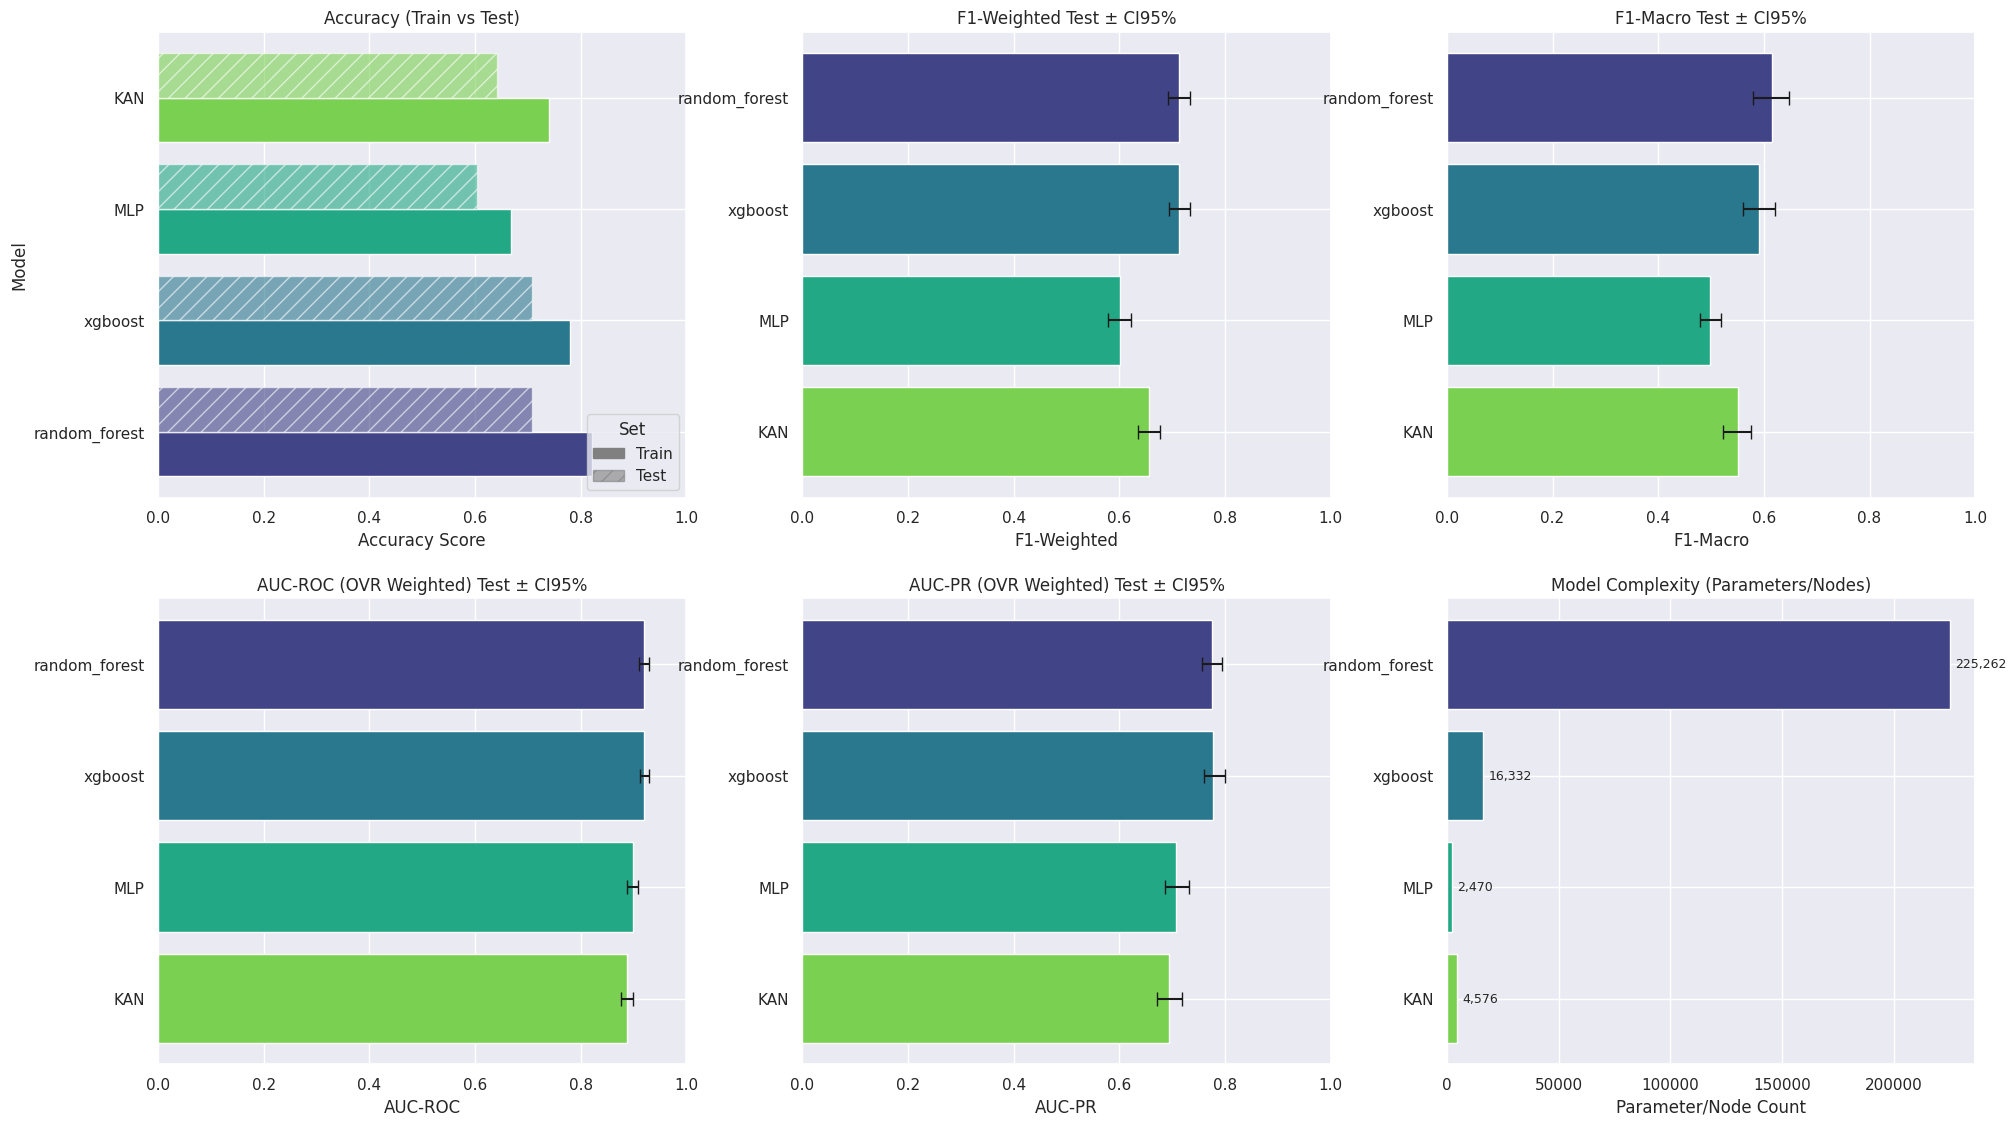

In [234]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model', 'Param_Count',
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [235]:
# 1) Define metrics and their optimization direction
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Build ranking DataFrame
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Param_Count'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Param_Count'] = df_ranks['Param_Count']

for method_name, score_col in methods.items():
    best_model = ranks[score_col].idxmin() if 'pareto' not in score_col else ranks[score_col].idxmin()
    best_score = ranks.loc[best_model, score_col]
    results_summary[method_name] = ranks[score_col]
    print(f"{method_name:25} -> {best_model:15} (score: {best_score:.3f})")

print("\n" + "="*70)
print("DETAILED RANKING TABLE")
print("="*70)

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Param_Count'] = df_ranks['Param_Count'].astype(int)
ranking_display['Avg_Performance'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
display(ranking_display_sorted)

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Param_Count']
recommended_f1 = df_ranks.loc[recommended_model, 'F1_Weighted_Test']

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   Reason: Best balance between performance and complexity")
print(f"   Parameters: {int(recommended_params):,}")
print(f"   F1-Weighted Score: {recommended_f1:.4f}")
print(f"   Complexity-Weighted Rank Score: {recommended_score:.3f}")

# Show top 3 models for comparison
print(f"\n  TOP 3 MODELS (Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Param_Count'])
    f1_value = df_ranks.loc[model, 'F1_Weighted_Test']
    print(f"   {i}. {model:15} | Params: {params:>8,} | F1: {f1_value:.4f} | Score: {row['complexity_weighted_score']:.3f}")

Equal Weight (1:1)        -> MLP             (score: 4.600)
Complexity Weighted (1:2) -> MLP             (score: 5.600)
Extreme Complexity (1:3)  -> MLP             (score: 6.600)
Pareto Approach (40:60)   -> MLP             (score: 0.400)

DETAILED RANKING TABLE


,Param_Count,Avg_Performance,Complexity_Rank,Equal_Rank,Extreme_Rank,Pareto_Rank
Model,,,,,,
MLP,2470,3.6,1,1,1,1
KAN,4576,3.4,2,4,2,3
xgboost,16332,1.7,3,2,3,2
random_forest,225262,1.3,4,3,4,4



RECOMMENDATION
   RECOMMENDED MODEL: MLP
   Reason: Best balance between performance and complexity
   Parameters: 2,470
   F1-Weighted Score: 0.6009
   Complexity-Weighted Rank Score: 5.600

  TOP 3 MODELS (Complexity-Weighted Ranking):
   1. MLP             | Params:    2,470 | F1: 0.6009 | Score: 5.600
   2. KAN             | Params:    4,576 | F1: 0.6555 | Score: 7.400
   3. xgboost         | Params:   16,332 | F1: 0.7126 | Score: 7.700


# Ablation Study MLP e KAN

=== STANDALONE MLP/KAN PRUNING STUDY ===

=== Standalone L1 Pruning Study for MLP ===
NOTA: MLP è un modello MLP standalone
Total Parameters: 2,470

Testing MLP pruning ratio: 0.0000
  Sparsity: 0.000
  Active params: 2,470 / 2,470
  Compression: 1.00x
  Accuracy: 0.6030
  F1-Weighted: 0.6009

Testing MLP pruning ratio: 0.1000
  Applied L1 pruning to standalone MLP with ratio: 0.100
  Sparsity: 0.100
  Active params: 2,223 / 2,470
  Compression: 1.11x
  Accuracy: 0.6091
  F1-Weighted: 0.6091

Testing MLP pruning ratio: 0.2000
  Applied L1 pruning to standalone MLP with ratio: 0.200
  Sparsity: 0.200
  Active params: 1,976 / 2,470
  Compression: 1.25x
  Accuracy: 0.6010
  F1-Weighted: 0.6013

Testing MLP pruning ratio: 0.3000
  Applied L1 pruning to standalone MLP with ratio: 0.300
  Sparsity: 0.300
  Active params: 1,729 / 2,470
  Compression: 1.43x
  Accuracy: 0.5673
  F1-Weighted: 0.5561

Testing MLP pruning ratio: 0.5000
  Applied L1 pruning to standalone MLP with ratio: 0.500
  Spa

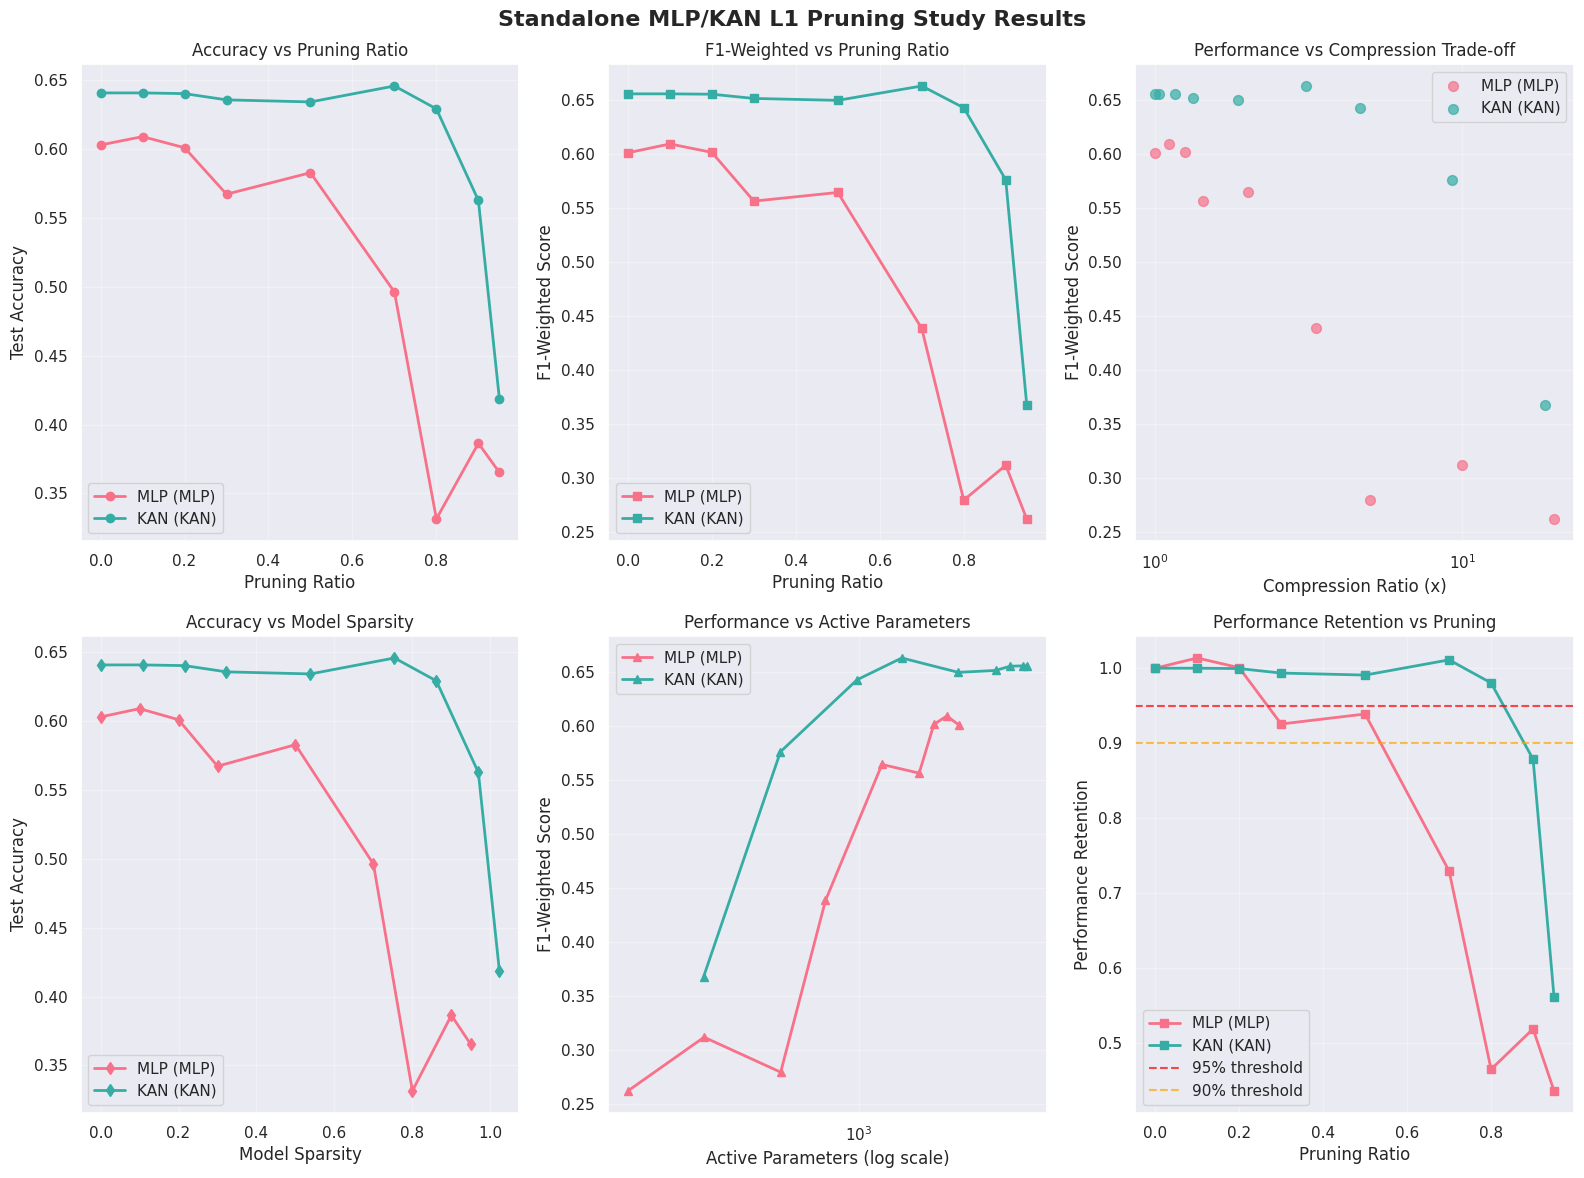


STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT

MLP Results:
--------------------------------------------------
Model Type: MLP
Total Parameters: 2,470
Baseline F1-Weighted: 0.6009
Significant degradation starts at: 30.0% pruning

Best trade-off point:
  Pruning ratio: 20.0%
  Compression: 1.2x
  F1_Weighted: 0.6013
  Performance loss: -0.1%

Maximum compression achieved: 19.9x

KAN Results:
--------------------------------------------------
Model Type: KAN
Total Parameters: 4,576
Baseline F1-Weighted: 0.6555
Significant degradation starts at: 90.0% pruning

Best trade-off point:
  Pruning ratio: 80.0%
  Compression: 4.6x
  F1_Weighted: 0.6426
  Performance loss: 2.0%

Maximum compression achieved: 18.6x

COMPARATIVE SUMMARY TABLE - STANDALONE MODELS
Model Type Pruning_Ratio Compression F1_Score Perf_Loss
  MLP  MLP           30%        1.4x   0.5561      7.5%
  MLP  MLP           50%        2.0x   0.5641      6.1%
  MLP  MLP           70%        3.3x   0.4382     27.1%
  MLP  

,model_name,model_type,pruning_ratio,sparsity,total_params,active_params,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,MLP,MLP,0.00,0.000000,2470,2470,1.000000,0.603023,0.600880,0.498765,0.898429,0.707430
1,MLP,MLP,0.10,0.100000,2470,2223,1.111111,0.609068,0.609074,0.505736,0.898771,0.708384
2,MLP,MLP,0.20,0.200000,2470,1976,1.250000,0.601008,0.601269,0.490205,0.898260,0.704548
3,MLP,MLP,0.30,0.300000,2470,1729,1.428571,0.567254,0.556113,0.461065,0.893019,0.695253
4,MLP,MLP,0.50,0.500000,2470,1235,2.000000,0.582872,0.564135,0.460284,0.886976,0.680796
5,MLP,MLP,0.70,0.700000,2470,741,3.333333,0.496222,0.438160,0.382353,0.889557,0.708506
6,MLP,MLP,0.80,0.800000,2470,494,5.000000,0.331486,0.279145,0.259103,0.866980,0.635235
7,MLP,MLP,0.90,0.900000,2470,247,10.000000,0.386398,0.311538,0.191402,0.748923,0.494023
8,MLP,MLP,0.95,0.949798,2470,124,19.919355,0.365239,0.261812,0.156464,0.661660,0.435008
9,KAN,KAN,0.00,0.000000,4576,4576,1.000000,0.640806,0.655460,0.550926,0.887913,0.693328


In [236]:
class StandalonePruningAblationStudy:
    def __init__(self, device='cpu'):
        self.device = device
        self.pruning_results = []

    def get_model_sparsity(self, model):
        """Calcola la sparsità per modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                # Calcola parametri totali KAN usando count_params esistente
                total_params = count_params(model)

                # Conta i parametri zero nella componente KAN
                zero_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        # Accedi ai coefficienti spline (coef parameter)
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            zero_params += float(torch.sum(layer.coef == 0))

                return zero_params / total_params if total_params > 0 else 0.0

            except Exception as e:
                print(f"  Error calculating KAN sparsity: {e}")
                return 0.0

        else:
            # Modello MLP standalone
            zero_params = 0
            total_params = count_params(model)

            # Conta parametri zero in tutti i layer Linear
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        zero_params += float(torch.sum(module.weight == 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        zero_params += float(torch.sum(module.bias == 0))

            return zero_params / total_params if total_params > 0 else 0.0

    def count_active_parameters(self, model):
        """Conta i parametri attivi nei modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                active_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            active_params += float(torch.sum(layer.coef != 0))

                return int(active_params)
            except:
                return count_params(model)

        else:
            # Modello MLP standalone
            active_params = 0
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        active_params += float(torch.sum(module.weight != 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        active_params += float(torch.sum(module.bias != 0))

            return int(active_params)


    def apply_l1_pruning_standalone(self, model, pruning_ratio):
        """Applica L1 norm pruning a modelli MLP/KAN standalone"""
        pruned_model = copy.deepcopy(model)

        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                if pruning_ratio == 0.0:
                    return pruned_model

                # Colleziona tutti i parametri KAN per L1 pruning globale
                kan_modules_to_prune = []
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = pruned_model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            temp_module = torch.nn.Linear(1, 1, bias=False)
                            temp_module.weight = torch.nn.Parameter(layer.coef.view(-1, 1))
                            kan_modules_to_prune.append((temp_module, 'weight'))


                if kan_modules_to_prune:
                    # Applica L1 pruning globale sui parametri KAN
                    prune.global_unstructured(
                        kan_modules_to_prune,
                        pruning_method=prune.L1Unstructured,
                        amount=pruning_ratio,
                    )

                    # Applica le maschere ai coefficienti originali
                    idx = 0
                    for i in range(len(model.width) - 1):
                        if i < len(model.act_fun):
                            layer = pruned_model.act_fun[i]
                            if hasattr(layer, 'coef') and layer.coef is not None:
                                original_shape = layer.coef.shape
                                mask = kan_modules_to_prune[idx][0].weight_mask.view(original_shape)
                                layer.coef.data = layer.coef.data * mask
                                idx += 1

                    # Rimuove le maschere temporanee
                    for module, param_name in kan_modules_to_prune:
                        prune.remove(module, param_name)

                print(f"  Applied L1 pruning to standalone KAN with ratio: {pruning_ratio:.3f}")
                return pruned_model

            except Exception as e:
                print(f"  Error during KAN L1 pruning: {e}")
                return model

        else:
            # Modello MLP standalone
            modules_to_prune = []

            # Colleziona tutti i layer Linear
            for module in pruned_model.modules():
                if isinstance(module, torch.nn.Linear):
                    modules_to_prune.append((module, 'weight'))
                    if hasattr(module, 'bias') and module.bias is not None:
                        modules_to_prune.append((module, 'bias'))

            if modules_to_prune:
                # Applica L1 pruning globale
                prune.global_unstructured(
                    modules_to_prune,
                    pruning_method=prune.L1Unstructured,
                    amount=pruning_ratio,
                )

                # Rende permanente il pruning
                for module, param_name in modules_to_prune:
                    prune.remove(module, param_name)

            print(f"  Applied L1 pruning to standalone MLP with ratio: {pruning_ratio:.3f}")
            return pruned_model


    def evaluate_pruned_model(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello pruned su dati tabulari"""
        # Ensure the model is on the correct device
        model.to(self.device)
        model.eval()

        # Converte in tensori, se necessario, e sposta sul device
        if not isinstance(X_test, torch.Tensor):
            X_test = torch.FloatTensor(X_test).to(self.device)
        else:
            X_test = X_test.to(self.device)

        if not isinstance(y_test, torch.Tensor):
            y_test = torch.LongTensor(y_test).to(self.device)
        else:
             y_test = y_test.to(self.device)

        if not isinstance(X_train, torch.Tensor):
            X_train = torch.FloatTensor(X_train).to(self.device)
        else:
            X_train = X_train.to(self.device)

        if not isinstance(y_train, torch.Tensor):
            y_train = torch.LongTensor(y_train).to(self.device)
        else:
            y_train = y_train.to(self.device)


        # Predizioni
        with torch.no_grad():
            # Test set
            outputs_test = model(X_test)
            y_pred_test = torch.argmax(outputs_test, dim=1)
            y_proba_test = F.softmax(outputs_test, dim=1)

            # Train set
            outputs_train = model(X_train)
            y_pred_train = torch.argmax(outputs_train, dim=1)

        # Converte in NumPy per le metriche
        y_pred_test = y_pred_test.cpu().numpy()
        y_true_test = y_test.cpu().numpy()
        y_proba_test = y_proba_test.cpu().numpy()
        y_pred_train = y_pred_train.cpu().numpy()
        y_true_train = y_train.cpu().numpy()


        # Calcola metriche
        accuracy = accuracy_score(y_true_test, y_pred_test)
        f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC
        try:
            auc_roc = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')
        except ValueError:
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }


    def run_standalone_pruning_study(self, model, model_name, X_test, y_test, X_train, y_train,
                                   pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]):
        """
        Conduce lo studio di ablazione con L1 pruning su modelli standalone MLP/KAN
        """
        print(f"\n=== Standalone L1 Pruning Study for {model_name} ===")

        # Determina il tipo di modello
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            model_type = "KAN"
            print(f"NOTA: {model_name} è un modello KAN standalone")
        else:
            model_type = "MLP"
            print(f"NOTA: {model_name} è un modello MLP standalone")

        # Parametri totali usando count_params
        total_params = count_params(model)
        print(f"Total Parameters: {total_params:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting {model_type} pruning ratio: {pruning_ratio:.4f}")

            if pruning_ratio == 0.0:
                # Modello originale
                pruned_model = model
                sparsity = 0.0
                active_params = total_params
            else:
                # Applica L1 pruning
                pruned_model = self.apply_l1_pruning_standalone(model, pruning_ratio)
                pruned_model.to(self.device)
                sparsity = self.get_model_sparsity(pruned_model)
                active_params = self.count_active_parameters(pruned_model)

            # Valuta prestazioni
            metrics = self.evaluate_pruned_model(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Calcola statistiche di compressione
            compression_ratio = total_params / active_params if active_params > 0 else float('inf')

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': model_type,
                'pruning_ratio': pruning_ratio,
                'sparsity': sparsity,
                'total_params': total_params,
                'active_params': active_params,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Sparsity: {sparsity:.3f}")
            print(f"  Active params: {active_params:,} / {total_params:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")


    def plot_standalone_pruning_results(self, figsize=(16, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli standalone
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Standalone MLP/KAN L1 Pruning Study Results', fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("husl", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: Performance vs Compression Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({model_type})', color=colors[i], s=50, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 4: Sparsity vs Performance
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['sparsity'], model_data['accuracy'],
                   marker='d', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Model Sparsity')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Model Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 5: Active Parameters vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.semilogx(model_data['active_params'], model_data['f1_weighted'],
                       marker='^', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Active Parameters (log scale)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Active Parameters')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: Performance Retention
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            model_type = model_data.iloc[0]['model_type']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_standalone_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning standalone
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_params = baseline_row['total_params']
            model_type = baseline_row['model_type']

            print(f"Model Type: {model_type}")
            print(f"Total Parameters: {total_params:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - STANDALONE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]
            model_type = baseline['model_type']

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Type': model_type,
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

print("=== STANDALONE MLP/KAN PRUNING STUDY ===")

standalone_pruning_study = StandalonePruningAblationStudy(device=device)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_mlp,
    model_name='MLP',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_kan,
    model_name='KAN',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.plot_standalone_pruning_results()
standalone_pruning_study.generate_standalone_pruning_report()

results_df = pd.DataFrame(standalone_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(results_df)} rows")
print("\nPruning results:")
display(results_df)

# Ablation Study RandomForest e XGBoost

In [237]:
# Ablation Study Ensemble Pruning: Random Forest e XGBoost

class EnsemblePruningAblationStudy:
    def __init__(self):
        self.pruning_results = []

    def rank_based_pruning_rf(self, rf_model, pruning_ratio):
        """
        Implementa Rank-Based Pruning per Random Forest.
        Rimuove gli alberi con le feature importance più basse.
        """
        if pruning_ratio == 0.0:
            return rf_model, list(range(len(rf_model.estimators_)))

        # Calcola l'importanza di ogni albero basata sulla media delle feature importance
        tree_importances = []
        for i, tree in enumerate(rf_model.estimators_):
            # L'importanza dell'albero è la somma delle importanze delle sue feature
            tree_importance = np.sum(tree.feature_importances_)
            tree_importances.append((i, tree_importance))

        # Ordina gli alberi per importanza (decrescente)
        tree_importances.sort(key=lambda x: x[1], reverse=True)

        # Calcola quanti alberi mantenere
        n_trees_to_keep = max(1, int(len(rf_model.estimators_) * (1 - pruning_ratio)))

        # Seleziona gli indici degli alberi da mantenere
        selected_indices = [idx for idx, _ in tree_importances[:n_trees_to_keep]]
        selected_indices.sort()  # Mantieni l'ordine originale

        # Crea un nuovo modello con solo gli alberi selezionati
        pruned_rf = copy.deepcopy(rf_model)
        pruned_rf.estimators_ = [rf_model.estimators_[i] for i in selected_indices]
        pruned_rf.n_estimators = len(selected_indices)

        return pruned_rf, selected_indices

    def cumulative_pruning_xgb(self, xgb_model, pruning_ratio):
        """
        Implementa Cumulative Pruning per XGBoost.
        Mantiene solo le prime iterazioni di boosting in base al pruning_ratio.
        """
        if pruning_ratio == 0.0:
            return xgb_model, list(range(xgb_model.n_estimators))

        # Ottieni il booster
        original_booster = xgb_model.get_booster()

        # Calcola il numero di alberi da mantenere
        total_trees = xgb_model.n_estimators
        num_classes = xgb_model.n_classes_
        total_rounds = total_trees // num_classes
        keep_rounds = max(1, int(total_rounds * (1 - pruning_ratio)))
        n_keep = keep_rounds * num_classes

        # Crea una copia del modello originale
        pruned_model = copy.deepcopy(xgb_model)
        pruned_model.n_estimators = n_keep

        def predict_pruned(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            predicted_labels = np.argmax(raw_predictions, axis=1)
            return predicted_labels

        def predict_proba(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            proba = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
            return proba

        pruned_model.predict = types.MethodType(predict_pruned, pruned_model)
        pruned_model.predict_proba = types.MethodType(predict_proba, pruned_model)

        selected_indices = list(range(n_keep))
        return pruned_model, selected_indices

    def evaluate_pruned_ensemble(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello ensemble pruned"""

        # Previsioni
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Calcola metriche
        accuracy = accuracy_score(y_test, y_pred_test)
        f1_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC (se il modello supporta predict_proba)
        try:
            if hasattr(model, 'predict_proba'):
                y_proba_test = model.predict_proba(X_test)
                auc_roc = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
                auc_pr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')
            else:
                auc_roc = np.nan
                auc_pr = np.nan
        except (ValueError, AttributeError):
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }

    def run_rf_pruning_study(self, rf_model, model_name, X_test, y_test, X_train, y_train,
                           pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Rank-Based Pruning su Random Forest
        """
        print(f"\n=== Rank-Based Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = len(rf_model.estimators_)
        print(f"Total Trees: {total_trees:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting RF pruning ratio: {pruning_ratio:.2f}")

            # Applica rank-based pruning
            pruned_model, selected_indices = self.rank_based_pruning_rf(rf_model, pruning_ratio)

            # Calcola statistiche
            remaining_trees = len(selected_indices)
            compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

            # Valuta prestazioni
            metrics = self.evaluate_pruned_ensemble(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': 'Random Forest',
                'pruning_method': 'Rank-Based',
                'pruning_ratio': pruning_ratio,
                'total_trees': total_trees,
                'remaining_trees': remaining_trees,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

    def run_xgb_pruning_study(self, xgb_model, model_name, X_test, y_test, X_train, y_train,
                            pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Cumulative Pruning su XGBoost
        """
        print(f"\n=== Cumulative Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = xgb_model.n_estimators
        print(f"Total Trees: {total_trees:,}")
        print(f"Number of Classes: {xgb_model.n_classes_}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting XGB pruning ratio: {pruning_ratio:.2f}")

            try:
                # Applica cumulative pruning
                pruned_model, selected_indices = self.cumulative_pruning_xgb(xgb_model, pruning_ratio)

                # Calcola statistiche
                remaining_trees = len(selected_indices)
                compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

                # Valuta prestazioni
                metrics = self.evaluate_pruned_ensemble(
                    pruned_model, model_name, X_test, y_test, X_train, y_train
                )

                # Salva risultati
                result = {
                    'model_name': model_name,
                    'model_type': 'XGBoost',
                    'pruning_method': 'Cumulative',
                    'pruning_ratio': pruning_ratio,
                    'total_trees': total_trees,
                    'remaining_trees': remaining_trees,
                    'compression_ratio': compression_ratio,
                    'accuracy': metrics['accuracy'],
                    'f1_weighted': metrics['f1_weighted'],
                    'f1_macro': metrics['f1_macro'],
                    'auc_roc': metrics['auc_roc'],
                    'auc_pr': metrics['auc_pr']
                }

                self.pruning_results.append(result)

                print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
                print(f"  Compression: {compression_ratio:.2f}x")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

            except Exception as e:
                print(f"  Error during XGB pruning at ratio {pruning_ratio}: {e}")
                continue

    def plot_ensemble_pruning_results(self, figsize=(18, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli ensemble
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(3, 3, figsize=figsize)
        fig.suptitle('Ensemble Pruning Study Results - Random Forest & XGBoost',
                     fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("Set1", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: F1-Macro vs Pruning Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_macro'],
                   marker='^', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Macro Score')
        ax.set_title('F1-Macro vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 4: Performance vs Compression Ratio
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({method})', color=colors[i], s=60, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 5: Remaining Trees vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.semilogx(model_data['remaining_trees'], model_data['accuracy'],
                       marker='d', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Remaining Trees (log scale)')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Remaining Trees')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: AUC-ROC vs Pruning Ratio
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            # Filtra i valori NaN per AUC
            valid_mask = ~np.isnan(model_data['auc_roc'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_roc'],
                       marker='*', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-ROC Score')
        ax.set_title('AUC-ROC vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 7: Performance Retention
        ax = axes[2, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 8: Trees Reduction vs Performance Loss
        ax = axes[2, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_loss = (baseline_f1 - model_data['f1_weighted']) / baseline_f1 * 100
            trees_reduction = (1 - model_data['remaining_trees'] / model_data['total_trees']) * 100
            ax.plot(trees_reduction, performance_loss,
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Trees Reduction (%)')
        ax.set_ylabel('Performance Loss (%)')
        ax.set_title('Trees Reduction vs Performance Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 9: Efficiency Comparison
        ax = axes[2, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            baseline_trees = model_data.iloc[0]['total_trees']
            baseline_f1 = model_data.iloc[0]['f1_weighted']

            # Calcola l'efficienza come F1-score per albero
            efficiency = model_data['f1_weighted'] / (model_data['remaining_trees'] / baseline_trees)
            ax.plot(model_data['pruning_ratio'], efficiency,
                   marker='x', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Efficiency (F1/Tree Fraction)')
        ax.set_title('Model Efficiency vs Pruning')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_ensemble_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning ensemble
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("ENSEMBLE PRUNING STUDY - DETAILED REPORT")
        print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_trees = baseline_row['total_trees']
            model_type = baseline_row['model_type']
            pruning_method = baseline_row['pruning_method']

            print(f"Model Type: {model_type}")
            print(f"Pruning Method: {pruning_method}")
            print(f"Total Trees: {total_trees:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Trees: {best_tradeoff['remaining_trees']:,} / {total_trees:,}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    trees_reduction = ((baseline['total_trees'] - closest['remaining_trees']) / baseline['total_trees']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Method': baseline['pruning_method'],
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Trees_Kept': f"{closest['remaining_trees']:,}",
                        'Trees_Reduction': f"{trees_reduction:.0f}%",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

ENSEMBLE PRUNING ABLATION STUDY
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning
Random Forest model extracted successfully

=== Rank-Based Pruning Study for Random Forest ===
Total Trees: 200

Testing RF pruning ratio: 0.00
  Remaining trees: 200 / 200
  Compression: 1.00x
  Accuracy: 0.1421
  F1-Weighted: 0.1477

Testing RF pruning ratio: 0.10
  Remaining trees: 180 / 200
  Compression: 1.11x
  Accuracy: 0.1406
  F1-Weighted: 0.1443

Testing RF pruning ratio: 0.20
  Remaining trees: 160 / 200
  Compression: 1.25x
  Accuracy: 0.1426
  F1-Weighted: 0.1488

Testing RF pruning ratio: 0.30
  Remaining trees: 140 / 200
  Compression: 1.43x
  Accuracy: 0.1431
  F1-Weighted: 0.1496

Testing RF pruning ratio: 0.40
  Remaining trees: 120 / 200
  Compression: 1.67x
  Accuracy: 0.1406
  F1-Weighted: 0.1463

Testing RF pruning ratio: 0.50
  Remaining trees: 100 / 200
  Compression: 2.00x
  Accuracy: 0.1355
  F1-Weighted: 0.1388

Testing RF pruning ratio: 0.60
  Remaining trees: 80 

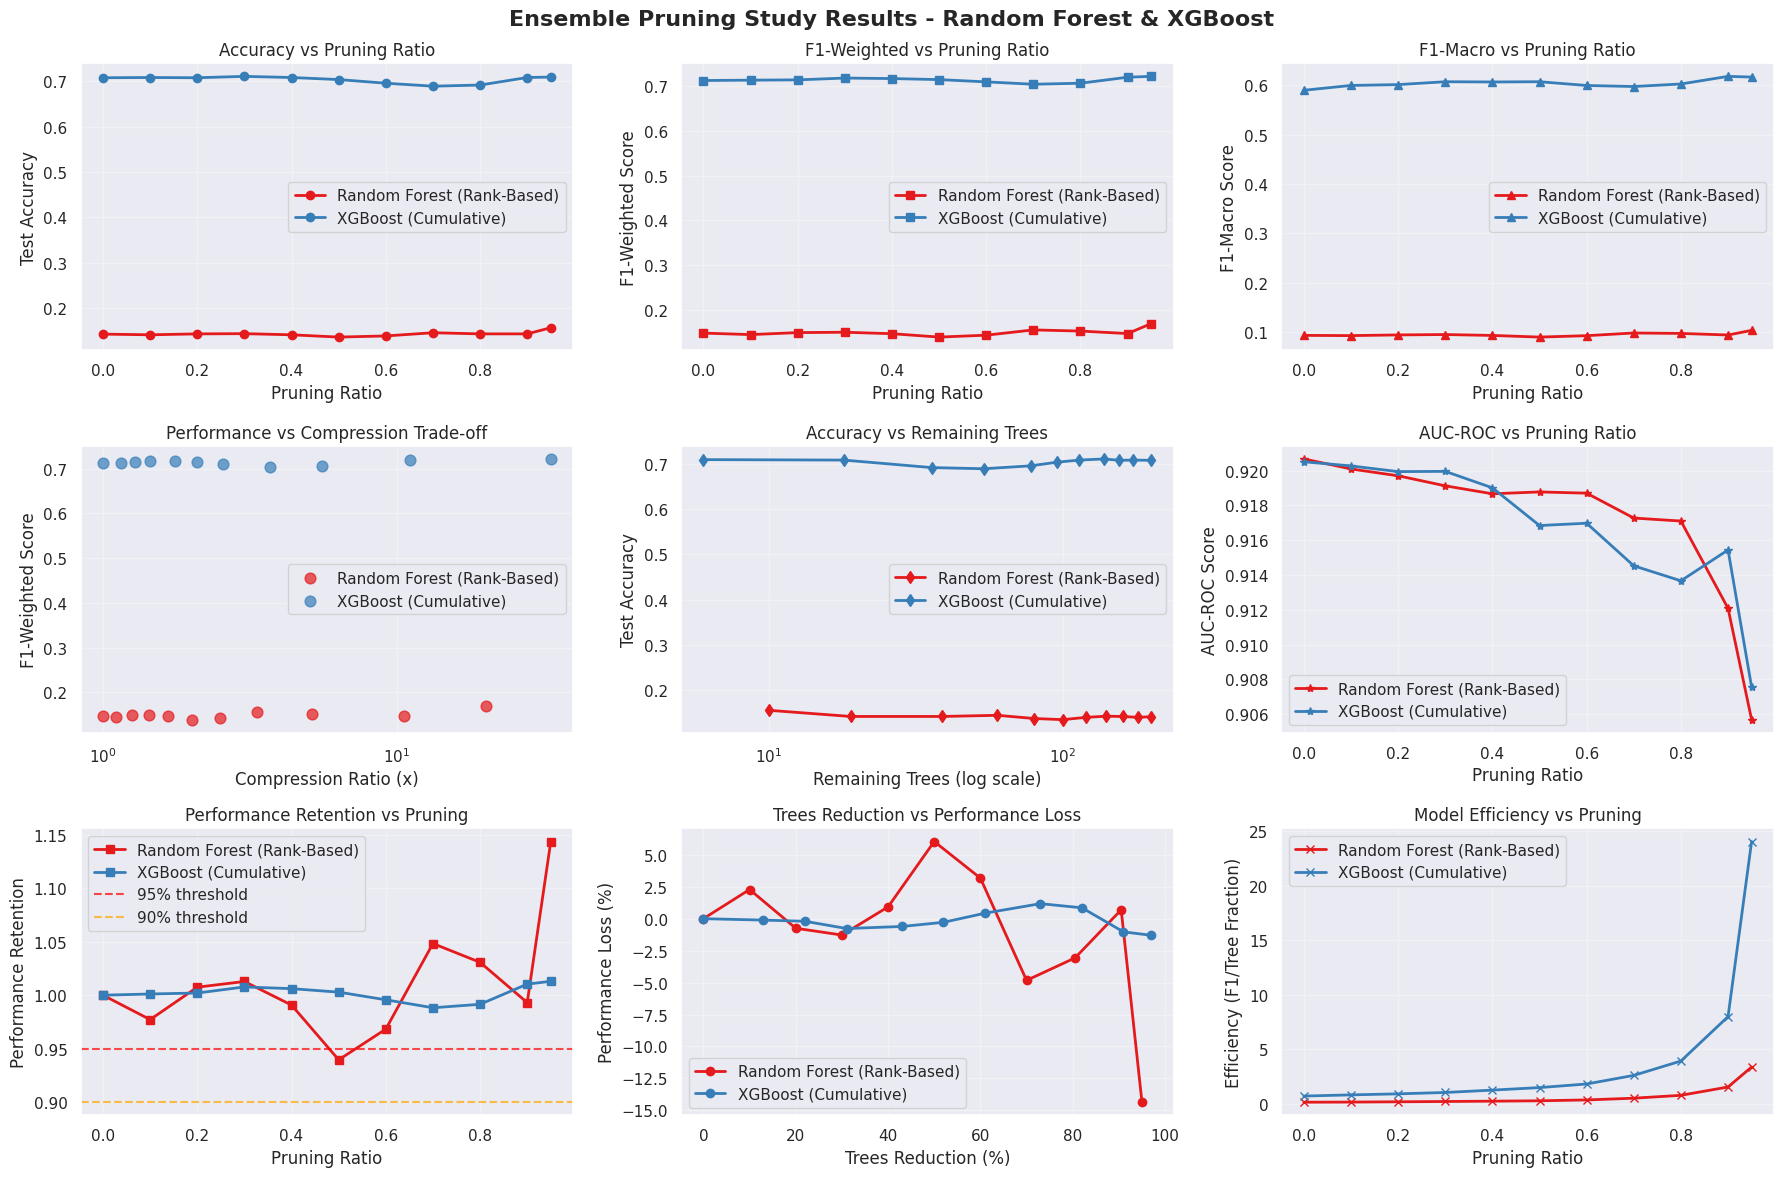


ENSEMBLE PRUNING STUDY - DETAILED REPORT
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning

Random Forest Results:
--------------------------------------------------
Model Type: Random Forest
Pruning Method: Rank-Based
Total Trees: 200
Baseline F1-Weighted: 0.1477
Significant degradation starts at: 50.0% pruning

Best trade-off point:
  Pruning ratio: 95.0%
  Trees: 10 / 200
  Compression: 20.0x
  F1_Weighted: 0.1689
  Performance loss: -14.4%

Maximum compression achieved: 20.0x

XGBoost Results:
--------------------------------------------------
Model Type: XGBoost
Pruning Method: Cumulative
Total Trees: 200
Baseline F1-Weighted: 0.7126
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 95.0%
  Trees: 6 / 200
  Compression: 33.3x
  F1_Weighted: 0.7219
  Performance loss: -1.3%

Maximum compression achieved: 33.3x

COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS
        Model     Method Pruning_Ratio Trees_Kept Trees_Reduction Co

,model_name,model_type,pruning_method,pruning_ratio,total_trees,remaining_trees,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,Random Forest,Random Forest,Rank-Based,0.00,200,200,1.000000,0.142065,0.147688,0.093449,0.920677,0.774577
1,Random Forest,Random Forest,Rank-Based,0.10,200,180,1.111111,0.140554,0.144318,0.092974,0.920100,0.773347
2,Random Forest,Random Forest,Rank-Based,0.20,200,160,1.250000,0.142569,0.148793,0.094378,0.919708,0.772724
3,Random Forest,Random Forest,Rank-Based,0.30,200,140,1.428571,0.143073,0.149579,0.095152,0.919129,0.771851
4,Random Forest,Random Forest,Rank-Based,0.40,200,120,1.666667,0.140554,0.146324,0.093337,0.918671,0.769489
5,Random Forest,Random Forest,Rank-Based,0.50,200,100,2.000000,0.135516,0.138771,0.090000,0.918778,0.770597
6,Random Forest,Random Forest,Rank-Based,0.60,200,80,2.500000,0.138035,0.143005,0.092815,0.918708,0.771661
7,Random Forest,Random Forest,Rank-Based,0.70,200,60,3.333333,0.145088,0.154817,0.098299,0.917276,0.768379
8,Random Forest,Random Forest,Rank-Based,0.80,200,39,5.128205,0.142569,0.152222,0.097412,0.917103,0.767418
9,Random Forest,Random Forest,Rank-Based,0.90,200,19,10.526316,0.142569,0.146662,0.094218,0.912081,0.752574


In [238]:
print("ENSEMBLE PRUNING ABLATION STUDY")
print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
print("="*100)

ensemble_pruning_study = EnsemblePruningAblationStudy()

pruning_ratios_ensemble = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

try:
    if 'tree' in gs_rf.best_estimator_.named_steps:
        rf_final_model = gs_rf.best_estimator_.named_steps['tree']
    else:
        raise ValueError("Random Forest model not found")

    print("Random Forest model extracted successfully")

    ensemble_pruning_study.run_rf_pruning_study(
        rf_model=rf_final_model,
        model_name='Random Forest',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with Random Forest model: {e}")

try:
    if 'xgb' in gs_xgb.best_estimator_.named_steps:
        xgb_final_model = gs_xgb.best_estimator_.named_steps['xgb']
    else:
        raise ValueError("XGBoost model not found")

    print("XGBoost model extracted successfully")

    ensemble_pruning_study.run_xgb_pruning_study(
        xgb_model=xgb_final_model,
        model_name='XGBoost',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with XGBoost model: {e}")

ensemble_pruning_study.plot_ensemble_pruning_results()
ensemble_pruning_study.generate_ensemble_pruning_report()

ensemble_results_df = pd.DataFrame(ensemble_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(ensemble_results_df)} rows")
print("\nPruning results:")
display(ensemble_results_df)

# Ablation Study Comparation

In [ ]:
def compare_all_pruning_methods():
    """
    Compare pruning effectiveness across all model types
    """
    print("\n" + "="*120)
    print("COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS")
    print("="*120)

    # Collect data from both studies
    all_models_comparison = []

    # Neural network results
    for _, result in results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Neural Network',
                'Pruning_Method': 'L1 Norm',
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Components': f"{result['active_params']}/{result['total_params']}"
            })

    # Ensemble results
    for _, result in ensemble_results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            pruning_method = 'Rank-Based' if result['model_name'] == 'Random Forest' else 'Cumulative'
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Ensemble',
                'Pruning_Method': pruning_method,
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Trees': f"{result['remaining_trees']}/{result['total_trees']}"
            })

    if all_models_comparison:
        comparison_df = pd.DataFrame(all_models_comparison)

        # Create pivot table for better visualization
        pivot_accuracy = comparison_df.pivot_table(
            values='Accuracy_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_f1_weighted = comparison_df.pivot_table(
            values='F1_Weighted_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_roc = comparison_df.pivot_table(
            values='AUC_ROC_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_pr = comparison_df.pivot_table(
            values='AUC_PR_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )

        print("\nAccuracy Performance Across Pruning Levels:")
        print(pivot_accuracy.round(4))

        print("\nF1 Weighted Performance Across Pruning Levels:")
        print(pivot_f1_weighted.round(4))

        print("\nAUC_ROC Weighted Performance Across Pruning Levels:")
        print(pivot_auc_roc.round(4))

        print("\nAUC_PR Weighted Performance Across Pruning Levels:")
        print(pivot_auc_pr.round(4))

        pruning_levels = [0.3, 0.5, 0.7, 0.9]
        
        print(f"\n{'='*120}")
        print("PERFORMANCE RETENTION AT DIFFERENT PRUNING LEVELS")
        print("="*120)
        
        for pruning_level in pruning_levels:
            print(f"\n{'-'*60}")
            print(f"PERFORMANCE RETENTION AT {int(pruning_level*100)}% PRUNING")
            print(f"{'-'*60}")
            
            retention_summary = []
            for model in comparison_df['Model'].unique():
                model_data = comparison_df[comparison_df['Model'] == model]
                baseline = model_data[model_data['Pruning_Ratio'] == 0.0]
                pruned = model_data[model_data['Pruning_Ratio'] == pruning_level]
                
                if len(baseline) > 0 and len(pruned) > 0:
                    baseline_acc = baseline.iloc[0]['Accuracy_Test']
                    pruned_acc = pruned.iloc[0]['Accuracy_Test']
                    retention = pruned_acc / baseline_acc if baseline_acc != 0 else 0
                    
                    retention_summary.append({
                        'Model': model,
                        'Type': baseline.iloc[0]['Type'],
                        'Method': baseline.iloc[0]['Pruning_Method'],
                        'Baseline_Accuracy': baseline_acc,
                        'Pruned_Accuracy': pruned_acc,
                        'Retention': retention,
                        'Compression': pruned.iloc[0]['Compression']
                    })
            
            if retention_summary:
                retention_df = pd.DataFrame(retention_summary).sort_values('Retention', ascending=False)
                print(retention_df.round(4))
            
            best_model = retention_df.iloc[0]
            print(f"\nBEST PRUNING METHOD AT {int(pruning_level*100)}% LEVEL:")
            print(f"Model: {best_model['Model']} ({best_model['Type']})")
            print(f"Method: {best_model['Method']}")
            print(f"Performance Retention: {best_model['Retention']:.1%}")
            print(f"Compression Achieved: {best_model['Compression']:.1f}x")

    else:
        print("No pruning results available for comparison.")

# Run comprehensive comparison
compare_all_pruning_methods()

print("\n" + "="*120)
print("ABLATION STUDY COMPLETE")


COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS

Accuracy Performance Across Pruning Levels:
Pruning_Ratio                                   0.0     0.3     0.5     0.7
Model         Type           Pruning_Method                                
KAN           Neural Network L1 Norm         0.6408  0.6358  0.6343  0.6458
MLP           Neural Network L1 Norm         0.6030  0.5673  0.5829  0.4962
Random Forest Ensemble       Rank-Based      0.1421  0.1431  0.1355  0.1451
XGBoost       Ensemble       Cumulative      0.7078  0.7108  0.7038  0.6892

F1 Weighted Performance Across Pruning Levels:
Pruning_Ratio                                   0.0     0.3     0.5     0.7
Model         Type           Pruning_Method                                
KAN           Neural Network L1 Norm         0.6555  0.6512  0.6494  0.6628
MLP           Neural Network L1 Norm         0.6009  0.5561  0.5641  0.4382
Random Forest Ensemble       Rank-Based      0.1477  0.1496  0.1388  0.1548
